In [ ]:
#Stevens Institute of Technology
#2023Summer CPE 695
#Professor. ShuCheng Yu
#Student Name: JiaHui Lian

#Final Project: Algorithm 2: LSTM

In [37]:
# Import necessary libraries
# Install yfinance, which provides tools to fetch financial data
%pip install yfinance
# Install TensorFlow, the deep learning library we'll be using
%pip install tensorflow
# Import required packages
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import precision_score

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [38]:
# Fetch the data
# Retrieve data for S&P 500
sp500 = yf.Ticker("^GSPC")
# Get all available historical data
sp500 = sp500.history(period="max")

In [39]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-08-14 00:00:00-04:00,4458.129883,4490.330078,4453.439941,4489.720215,3896410000,0.0,0.0
2023-08-15 00:00:00-04:00,4478.870117,4478.870117,4432.189941,4437.859863,3832250000,0.0,0.0
2023-08-16 00:00:00-04:00,4433.790039,4449.950195,4403.549805,4404.330078,3753910000,0.0,0.0


In [40]:
# Data preprocessing
# Filter data to get records from 1990 onwards
sp500 = sp500.loc["1990-01-01":].copy()
# Remove dividends and stock splits columns as they're not used in this analysis
del sp500["Dividends"]
del sp500["Stock Splits"]
# Remove any rows with missing data
sp500.dropna()

,Open,High,Low,Close,Volume
Date,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000
...,...,...,...,...,...
2023-08-14 00:00:00-04:00,4458.129883,4490.330078,4453.439941,4489.720215,3896410000
2023-08-15 00:00:00-04:00,4478.870117,4478.870117,4432.189941,4437.859863,3832250000
2023-08-16 00:00:00-04:00,4433.790039,4449.950195,4403.549805,4404.330078,3753910000


In [41]:
# Display general info about the data
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8473 entries, 1990-01-02 00:00:00-05:00 to 2023-08-18 00:00:00-04:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    8473 non-null   float64
 1   High    8473 non-null   float64
 2   Low     8473 non-null   float64
 3   Close   8473 non-null   float64
 4   Volume  8473 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 397.2 KB


In [42]:
# Extract 'Close' price for training
trainData = sp500.iloc[:,3:4].values
trainData

array([[ 359.69000244],
       [ 358.76000977],
       [ 355.67001343],
       ...,
       [4404.33007812],
       [4370.35986328],
       [4369.70996094]])

In [43]:
# Data normalization
# Initialize a scaler to normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
# Normalize the 'Close' price data for better performance in training
trainData = scaler.fit_transform(trainData)
trainData.shape

(8473, 1)

In [44]:
trainData

array([[0.01426985],
       [0.01406323],
       [0.01337673],
       ...,
       [0.91285908],
       [0.90531199],
       [0.90516761]])

In [45]:
# Create the dataset for LSTM
# Initialize lists to store training data
X = []
y = []

In [46]:
# Prepare data for training: For each day, use the past 60 days' data to predict the next day's close price
for i in range(60, len(trainData)): # 60: timestep // len(trainData): lenth of the data
    X.append(trainData[i-60:i,0])
    y.append(trainData[i,0])

# Convert lists to arrays
X, y = np.array(X), np.array(y)

In [47]:
# Reshape the data to 3D array for LSTM input, adding the batch size axis
X = np.reshape(X, (X.shape[0],X.shape[1],1))
X.shape

(8413, 60, 1)

In [48]:
# Build the LSTM model

# Build the LSTM model with 4 layers of LSTM network that all following by a dropout layer
# At the end, we have a final dense layer
# All these compiled with an adam optimizer, and the mean squared error as the loss function.

# Initialize a Sequential model
model = Sequential()

# Add four LSTM layers with dropout for regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense layer to get the predicted 'Close' price
model.add(Dense(units=1))

# Compile the model using adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mean_squared_error')


In [49]:
# Train the LSTM model
# Train the model using the training data with 20 epochs, and use 32 as batch_size
hist = model.fit(X, y, epochs = 20, batch_size = 32, verbose = 2)

Epoch 1/20
263/263 - 20s - loss: 0.0032 - 20s/epoch - 76ms/step
Epoch 2/20
263/263 - 16s - loss: 9.6950e-04 - 16s/epoch - 60ms/step
Epoch 3/20
263/263 - 16s - loss: 9.2385e-04 - 16s/epoch - 60ms/step
Epoch 4/20
263/263 - 16s - loss: 7.5763e-04 - 16s/epoch - 60ms/step
Epoch 5/20
263/263 - 16s - loss: 6.1356e-04 - 16s/epoch - 61ms/step
Epoch 6/20
263/263 - 16s - loss: 7.3757e-04 - 16s/epoch - 61ms/step
Epoch 7/20
263/263 - 16s - loss: 5.9152e-04 - 16s/epoch - 61ms/step
Epoch 8/20
263/263 - 16s - loss: 5.8998e-04 - 16s/epoch - 60ms/step
Epoch 9/20
263/263 - 16s - loss: 6.5547e-04 - 16s/epoch - 60ms/step
Epoch 10/20
263/263 - 16s - loss: 5.1191e-04 - 16s/epoch - 60ms/step
Epoch 11/20
263/263 - 16s - loss: 6.6715e-04 - 16s/epoch - 60ms/step
Epoch 12/20
263/263 - 16s - loss: 4.5044e-04 - 16s/epoch - 60ms/step
Epoch 13/20
263/263 - 16s - loss: 5.2670e-04 - 16s/epoch - 60ms/step
Epoch 14/20
263/263 - 16s - loss: 4.6853e-04 - 16s/epoch - 60ms/step
Epoch 15/20
263/263 - 16s - loss: 4.3601e-04 - 

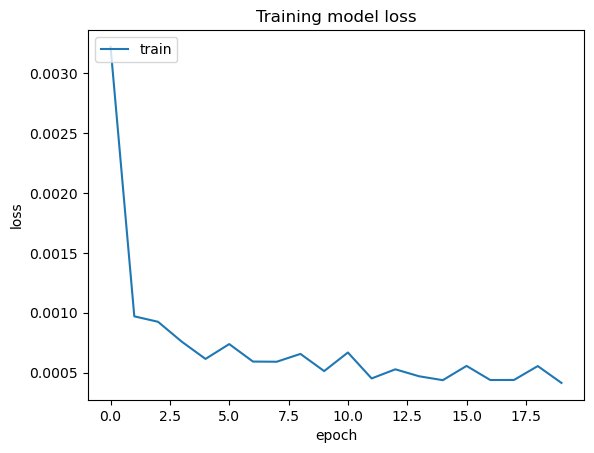

In [50]:
# Visualize the training loss
# Plot training loss over epochs
plt.plot(hist.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [65]:
# Test the LSTM model
# Fetch the testing dataset
testData = yf.Ticker("^GSPC")
testData = testData.history(period="max")
testData = testData.loc["1990-01-01":].copy()
# Similar preprocessing as before
del testData["Dividends"]
del testData["Stock Splits"]
testData.dropna()
# Extract the 'Close' price for testing
testData = testData.iloc[:,3:4]
y_test = testData.iloc[60:,0:].values
# input array for the model
inputClosing = testData.iloc[:,0:].values
# Normalize test data
inputClosing_scaled = scaler.transform(inputClosing)
inputClosing_scaled.shape

(8473, 1)

In [67]:
# Prepare test dataset similar to training dataset
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep, length):
    X_test.append(inputClosing_scaled[i-timestep:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(8413, 60, 1)

In [68]:
# Predict stock prices using the trained LSTM model
y_pred = model.predict(X_test)
y_pred

263/263 [==============================] - 4s 15ms/step


array([[0.01045504],
       [0.01046424],
       [0.01052491],
       ...,
       [0.9039227 ],
       [0.90210044],
       [0.8994099 ]], dtype=float32)

In [59]:
# Inverse transform the predicted values to get the actual predicted prices
predicted_price = scaler.inverse_transform(y_pred)

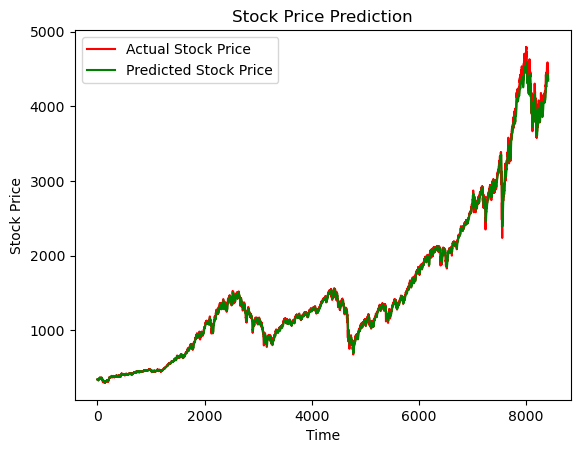

In [70]:
# Visualize the actual vs predicted stock prices
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [71]:
# Evaluate the model's performance
# Derive the predicted direction of stock price movement
predicted_movement = np.sign(predicted_price[1:] - predicted_price[:-1]).flatten()

# Derive the actual direction of stock price movement
actual_movement = np.sign(y_test[1:] - y_test[:-1]).flatten()

# Calculate model accuracy based on direction of stock movement
correct_preds = np.where(predicted_movement == actual_movement, 1, 0)
accuracy = correct_preds.sum() / correct_preds.size
print(f"Accuracy: {accuracy:.2f}")

# Check the model precision for predicting upward movement
precision = precision_score(np.where(actual_movement == 1, 1, 0), 
                            np.where(predicted_movement == 1, 1, 0))
print(f"Precision: {precision:.2f}")


Accuracy: 0.49
Precision: 0.52
